# Neural network setup customization

<em style="color:gray;">Copyright (c) 2024 QuAIR team. All Rights Reserved.</em>

In the previous tutorial, we demonstrated how to build a quantum neural network, specifically a single quantum circuit, to solve the VQE problem. But what if you want to set up a neural network that includes multiple quantum circuits with shared parameters for gradient analysis, along with a classical neural network for post-processing information? This tutorial introduces a general framework in QuAIRKit for customizing quantum neural networks or classical-quantum hybrid neural networks, as well as managing parameters effectively.

**Table of contents**

- [Setup via quairkit.Circuit](#Setup-via-quairkit.Circuit)
- [Setup via torch.nn.Module](#Setup-via-torch.nn.Module)

In [1]:
import torch

import quairkit as qkit
from quairkit import Circuit, State, Hamiltonian
from quairkit.database import *
from quairkit.loss import *
from quairkit.qinfo import *

## Setup via quairkit.Circuit

If you are satisfied with QuAIRKit's built-in circuit ansatzes and parameter gate structures, and have no special needs for parameter generation or management, we recommend constructing a neural network model using the `Circuit` class.

 Previous tutorials have covered how to construct a quantum circuit or insert a gate/channel. Here, we focus on the built-in parameter management functionality provided by `Circuit`. Let's start with the following circuit.

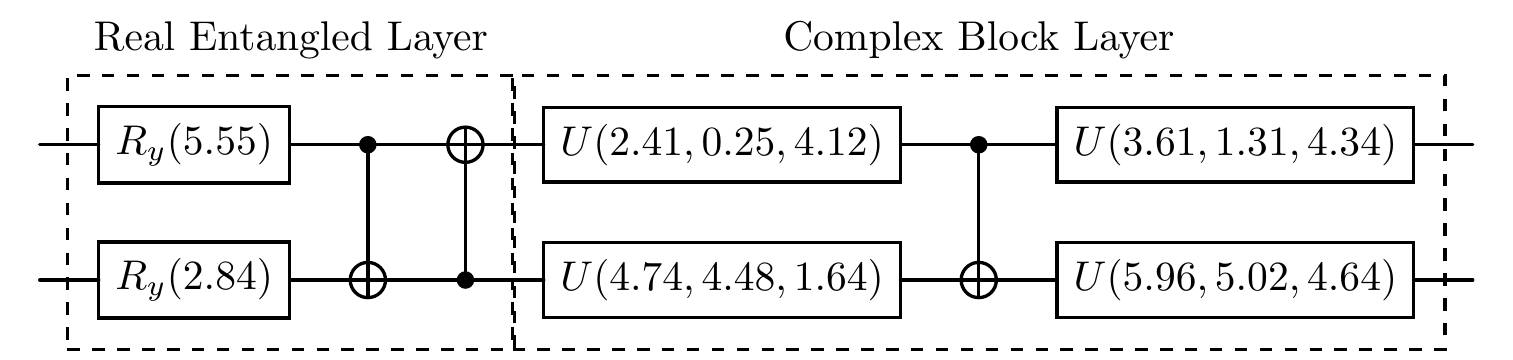

In [2]:
cir = Circuit(2)
cir.real_entangled_layer() # a layer of Ry and CNOT
cir.complex_block_layer() # a layer of U3 and CNOT

cir.plot()

The parameters of the circuit can be revised by ``update_param``. If the parameter gate has no input about parameters, the default parameters are uniformly sampled from 0 to $2\pi$.

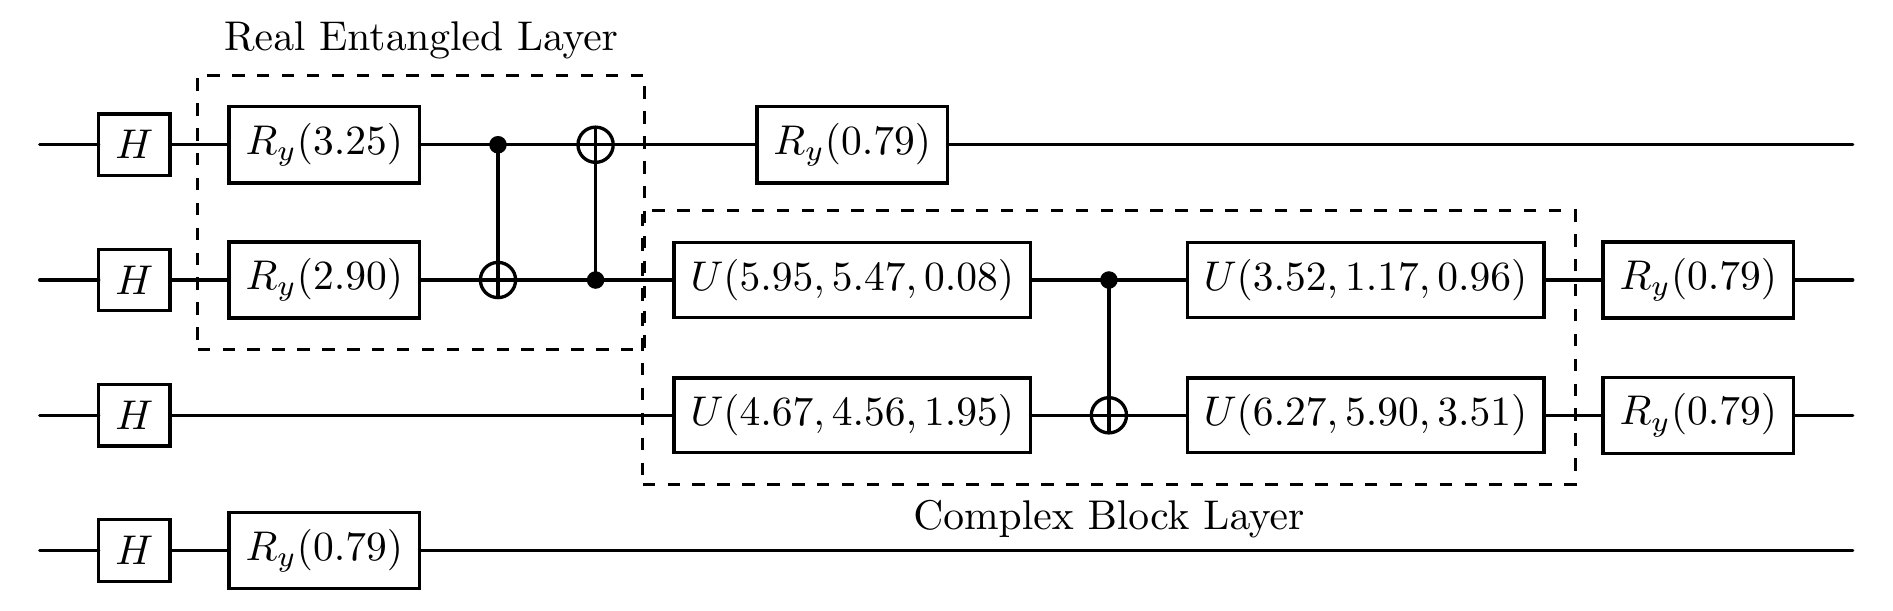

circuit after updating the parameters


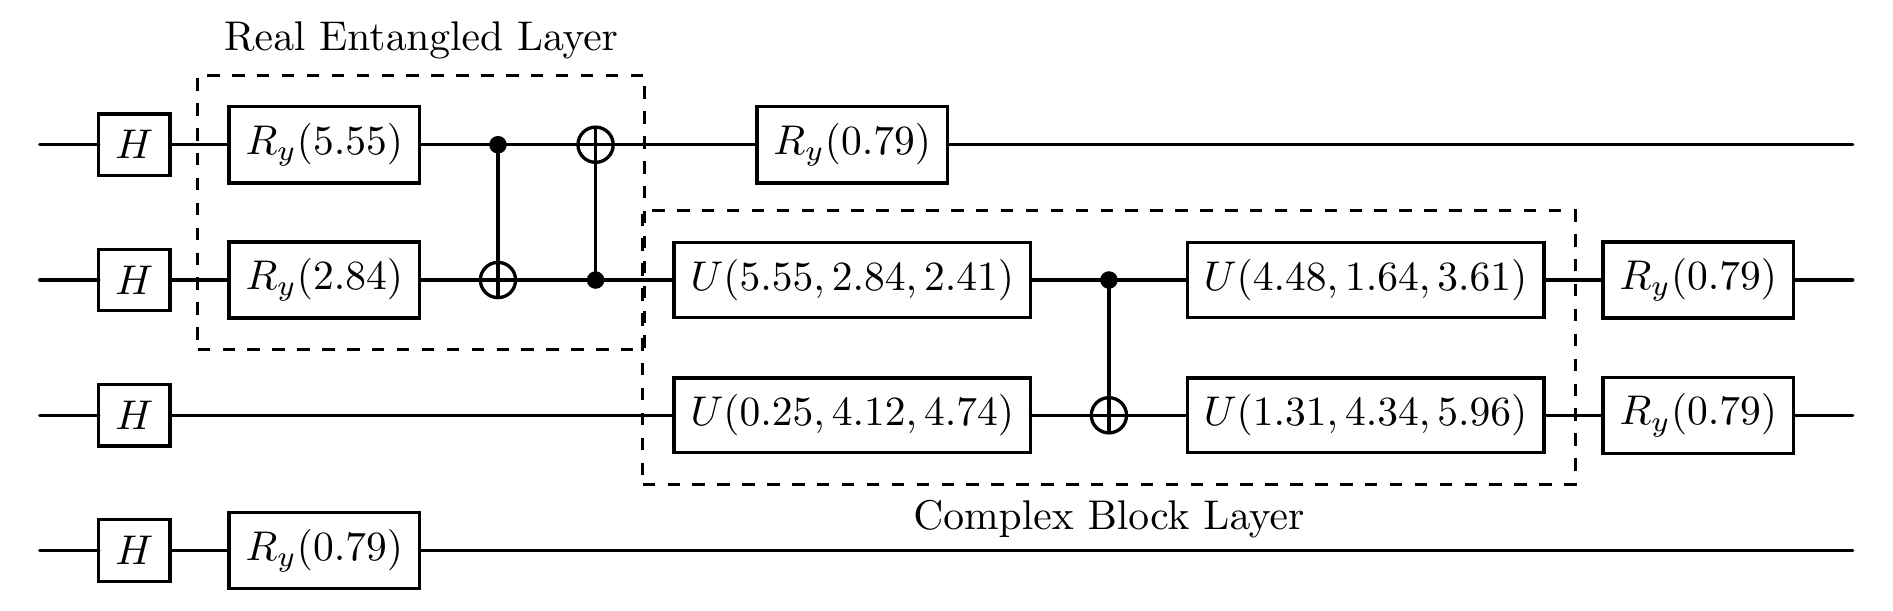

In [3]:
new_cir = Circuit(4)

new_cir.h() # a layer of Hadamard
new_cir.real_entangled_layer([0, 1])
new_cir.complex_block_layer([1, 2])
new_cir.ry(param=torch.pi / 4) # a layer of fixed Ry

new_cir.plot() 
new_cir.update_param(cir.param) 

print('circuit after updating the parameters')
new_cir.plot()

The `Circuit` class also provides adjustable options for uniform sampling and Gaussian sampling methods.

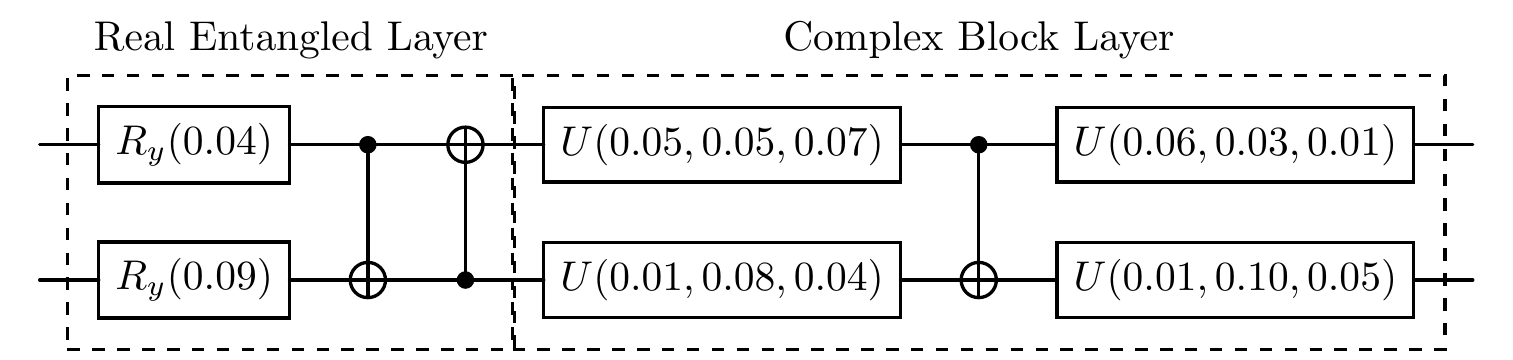

In [4]:
cir.randomize_param(0, 0.1, method='uniform') # use uniform sampling to generate the parameters.
cir.plot()

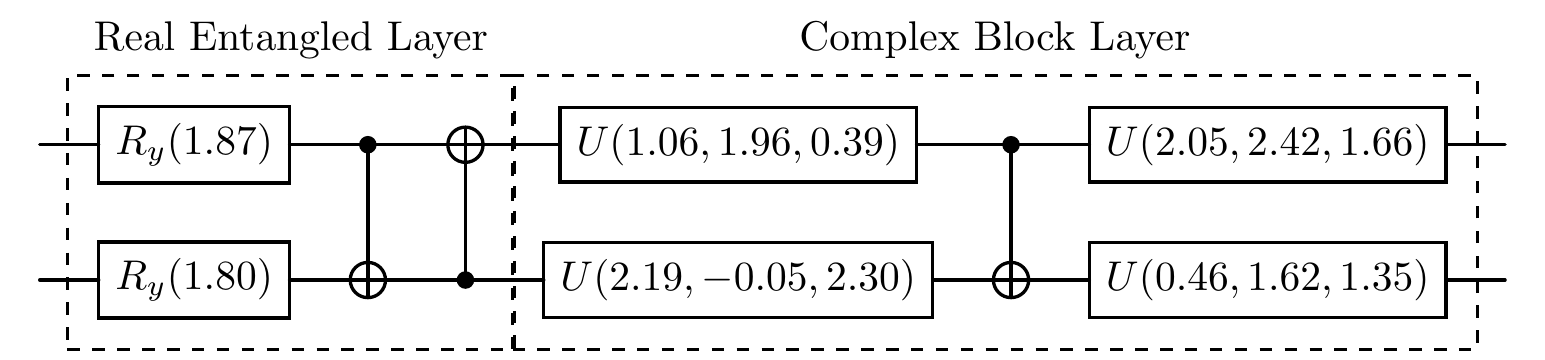

In [5]:
cir.randomize_param(1, 1.1, method='normal') # use Gaussian sampling to generate the parameters.
cir.plot()

What if you just want to manipulate the parameter of a particular gate? One can visit all elements of the `Circuit` through indexing. In this way, users can also access or modify the parameter of the specific gate.

In [6]:
cir

Circuit(
  (0): RealEntangledLayer(
    (0): RY()
    (1): CNOT()
  )
  (1): ComplexBlockLayer(
    (0): U3()
    (1): CNOT()
    (2): U3()
  )
)

In [7]:
first_gate = cir[0][0]
print('The parameters of first two RY gates are\n', list(first_gate.parameters()))
print('The Kraus representations of the first two RY gates are: \n', first_gate.kraus_repr)

The parameters of first two RY gates are
 [Parameter containing:
tensor([[[1.8684]],

        [[1.7971]]], requires_grad=True)]
The Kraus representations of the first two RY gates are: 
 tensor([[[[ 0.5945+0.j, -0.8041+0.j],
          [ 0.8041+0.j,  0.5945+0.j]]],


        [[[ 0.6227+0.j, -0.7824+0.j],
          [ 0.7824+0.j,  0.6227+0.j]]]], grad_fn=<UnsqueezeBackward0>)


In addition to parameter manipulations, the `Circuit` class also provides built-in interface for parameterized gate customizations. For example, suppose one wants to implement a controlled-U3 parameterized gate with control on the $\vert{11}\rangle$ state

$$
\left(I^{\otimes 2} - \vert 11 \rangle\langle 11 \vert\right) \otimes I +  \vert 11 \rangle\langle 11 \vert \otimes \operatorname{U3}({\bm \theta})
.$$

Such three-qubit gate could be implemented via the following code

In [8]:
def ccu3(theta: torch.Tensor) -> torch.Tensor:
    proj = computational_state(num_system=2, index=3).density_matrix
    return torch.kron((torch.eye(2) - proj), torch.eye(2)) + torch.kron(proj, u3(theta))

By providing the gate function, and the size of parameters, `param_oracle` would take care of any other messes, including the parameter management.

In [9]:
cir = Circuit(4)

cir.param_oracle(ccu3, num_acted_param=3, system_idx=[1, 2, 3], gate_name='ccu3')
# this is equivalent to below code
# cir.param_oracle(u3, num_acted_param=3, system_idx=[[1, 2], 3], control_idx=-1, gate_name='ccu3')

print('The parameters of this circuit are\n', list(cir.parameters()))

The parameters of this circuit are
 [Parameter containing:
tensor([[[1.6940, 1.0177, 3.8678]]], requires_grad=True)]


## Setup via torch.nn.Module

For more general machine learning tasks, such as classical-quantum hybrid machine learning, or if you're a machine learning researcher aligning with common practices, we recommend setting up the quantum neural network in the same way as a classical neural network—by creating a child class from `torch.nn.Module`.

Next, we will demonstrate how to construct a classical-quantum hybrid neural network using `torch.nn.Module`. We'll start by considering the quantum side, which involves inputting quantum data followed by a parameterized universal gate.

In [10]:
def create_cir(training_data: torch.Tensor, param: torch.Tensor) -> Circuit:
    r"""Create a quantum neural network circuit.
    
    Args:
        training_data: The input data.
        param: The parameters for the quantum layers.
    
    """
    circuit = Circuit(2)
    circuit.oracle(training_data, system_idx=[0, 1])
    circuit.u3(param=param)
    return circuit

The overall structure of our example neural network is as follows: The network first accepts a quantum state, which is passed through two quantum layers containing the training data. Quantum measurements are then performed to obtain expectation values with respect to the given Hamiltonian. These expectation values are subsequently passed through two classical fully connected layers to produce the final result.

<figure style="text-align: center;">
  <img src="figures/custom_network.png" alt="alt text" width="700"/>
  <figcaption>Fig.1: Depiction of below quantum-classical hybrid neural network with batch_size 100.</figcaption>
</figure>

In [11]:
class Network(torch.nn.Module):
    r"""A customized hybrid quantum-classical neural network.
    
    Args:
        batch_size: The batch dimension of input data.
        H: The Hamiltonian for measuring the neural network.
    
    Note:
        contains the following layers:
        - two quantum circuits
        - A fully connected (dense) layer that takes batch_size inputs and outputs 10 features
        - A second dense layer that takes the 10 features from fc1 and reduces them to a single output
    
    """
    def __init__(self, batch_size: int, H: Hamiltonian):
        super().__init__()
        
        self.training_data = random_unitary(2, size=(2, batch_size))
        self.theta = torch.nn.Parameter(torch.poisson(torch.rand(2, batch_size, 6)))
        self.measure = ExpecVal(H)
        
        self.fc1 = torch.nn.Linear(batch_size, 10)
        self.fc2 = torch.nn.Linear(10, 1)
        
    def forward(self, input_state: State) -> torch.Tensor:
        r"""Perform the forward propagation of the neural network.
        
        Args:
            input_state: The input quantum state of the neural network.
            
        Note:
            If the `Network` does not require custom parameters, 
            one can move the creation of `cir1` and `cir2` directly into 
            the `__init__` method to improve runtime efficiency.
        """
        cir1 = create_cir(self.training_data[0], self.theta[0])
        cir2 = create_cir(self.training_data[1], self.theta[1])
        
        state1 = cir1(input_state)
        state2 = cir2(state1)
        expectation = self.measure(state2)
        
        x = torch.relu(self.fc1(expectation))
        x = torch.sigmoid(self.fc2(x))
        return x

In [12]:
BATCH_SIZE = 100
ham = random_hamiltonian_generator(2)
net = Network(BATCH_SIZE, ham)

In the `Network` class, the parameters can be directly accessed through self-defined attributes, making it more convenient to modify parameters as needed.

In [13]:
net.theta = torch.nn.Parameter(torch.ones_like(net.theta))

Here is an example of passing a randomly-generated two-qubit quantum state through the network.

In [14]:
psi = random_state(2)
loss = net(psi)

loss.backward()

print("shape of the gradient tensor for the theta parameters", net.theta.grad.shape)

shape of the gradient tensor for the theta parameters torch.Size([2, 100, 6])


---

*Table: A reference of notation conventions in this tutorial.*

| Symbol        | Variant          | Description                               |
|:---------------:|:------------------:|-------------------------------------------|
|  $I$ |   |   Identity gate |
|$ \vert 11 \rangle$ | |  The fourth two-qubit computational state |
| $\operatorname{U3}$ |   |  Universal single-qubit gate (up to a global phase)  |
|  ${\bm \theta}$ |   |   Trainable parameters |

In [15]:
qkit.print_info()


---------VERSION---------
quairkit: 0.4.2
torch: 2.8.0+cu128
torch cuda: 12.8
numpy: 2.2.6
scipy: 1.15.3
matplotlib: 3.10.6
---------SYSTEM---------
Python version: 3.10.18
OS: Linux
OS version: #1 SMP Tue Nov 5 00:21:55 UTC 2024
---------DEVICE---------
CPU:  13th Gen Intel(R) Core(TM) i9-13980HX
GPU: (0) NVIDIA GeForce RTX 4090 Laptop GPU
